# Fase 1.1: Convertir la ResBaGAN inicial de PyTorch a ONXX

In [1]:
# Imports

import math,random,struct,os,time,sys
import numpy as np
import torch
import torch.nn as nn
import torch.onnx
import onnx
import onnxruntime as ort
from torchvision import models
from torch.utils.data import Dataset,DataLoader
from sklearn import preprocessing
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import time

# Funciones y parámetros de la ResBaGAN
import sys
sys.path.append('../src/')

import resbagan_networks
import resbagan_datasets
from cnn21_pix import read_pgm, save_pgm

## 1. Conversión de la ResBaGAN inicial de PyTorch a ONNX

### 1.1. Conversión del modelo

In [2]:
# Datos de entrada

batch_size = 100
B = 5
sizex = 32
sizey = 32

In [4]:
# Definir parámetros y cargar datos

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'
MODEL="../results/models/model_ResBaGAN.pt"

# Queremos usar todos los datos para la inferencia
SAMPLES=[0.0,0.0]

# Carga de datos para la inferencia en el discriminador
dataset = resbagan_datasets.HyperDataset(
    "oitaven_river", segmented=False, patch_size=32, ratios=(SAMPLES[0], SAMPLES[1]))

# Almacenamos las dimensiones en variables
H = dataset.height
V = dataset.width

samples = dataset.ordered_test_set['samples']

# Obtenemos el array de gt
truth = dataset.gt.flatten()
# Obtenemos un array de indices para test
test = dataset.test_index_list

# Obtenemos el numero de clases y el numero de clases no vacias para test
nclases = dataset.classes_count
nclases_no_vacias = 0
for i in range(nclases):
    clase_actual = i + 1
    if any(truth[idx] == clase_actual for idx in test):
        nclases_no_vacias += 1

print(dataset)

# The custom HyperDataset object contains all the train, validation and test data
#   --> But it will wrapped into a PyTorch data feeder for convenience
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

[*] Loading dataset oitaven_river from disk
	oitaven_river dataset is in RAW format
[*] Recording available classes
[*] Starting preprocessing
[*] Scaling dataset to [-1, 1]
[*] Splitting dataset into train, validation, and test sets: ratios (0.0, 0.0)
[*] Total samples: 6067179
	[*] Recording samples for class Water (309248 items)
	[*] Recording samples for class Bare soil (113324 items)
	[*] Recording samples for class Rock (79152 items)
	[*] Recording samples for class Asphalt (43861 items)
	[*] Recording samples for class Concrete (128022 items)
	[*] Recording samples for class Tiles (78785 items)
	[*] Recording samples for class Meadows (2428482 items)
	[*] Recording samples for class Native trees (1829360 items)
	[*] Recording samples for class Pines (193884 items)
	[*] Recording samples for class Eucalyptus (863061 items)

[*] HyperDataset summary:
	Name: oitaven_river
	Shape: (height) 6689, (width) 6722, (bands) 5
	Classes: ['Water', 'Bare soil', 'Rock', 'Asphalt', 'Concrete', 

In [5]:
# Cargar el modelo

cuda=True if torch.cuda.is_available() else False
device=torch.device('cuda' if cuda else 'cpu')
device='cpu'

if torch.backends.cudnn.is_available():
    print('* Activando CUDNN')
    torch.backends.cudnn.enabled=True
    torch.backends.cudnn.beBhmark=True

hyperparams = {
    "latent_size":   128,
    "activation":    "lrelu",
    "p_dropout":     0.05,
    "weight_init":   "xavier",
    "learning_rate": 0.001,
    "epochs":        100,
    "batch_size":    100,
    "num_workers":   4,
    "device":        "cpu",
}

# Cargar el discriminador
model = resbagan_networks.ResBaGAN_Discriminator(dataset=dataset, device=hyperparams["device"], hyperparams=hyperparams)

# Cargar los pesos guardados
model.load_state_dict(torch.load("../results/models/model_ResBaGAN_discriminator.pt"))
model.eval()

/tmp/ipykernel_47312/2524263855.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../results/models/model_ResBaGAN_discriminator.pt"))


ResBaGAN_Discriminator(
  (map_0): GAN_Discriminator_ConvBlock(
    (layers): Sequential(
      (0): ParametrizedConv2d(
        5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _SpectralNorm()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Dropout(p=0.05, inplace=False)
    )
  )
  (stage_1): GAN_Discriminator_ResStage(
    (blocks): Sequential(
      (0): GAN_Discriminator_ResBlock(
        (downsample): GAN_Discriminator_ConvBlock(
          (layers): Sequential(
            (0): ParametrizedConv2d(
              16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): _SpectralNorm()
                )
              )
            )
            (1): Dropout(p=0.05, inpl

In [7]:
# Definimos una función personalizada para la operación torch.vdot
# Esto se debe a que el conversor no soporta esta operación

def vdot_replacement(a, b):
    return torch.sum(torch.conj(a) * b)

In [8]:
# Asignamos la nueva operación torch.vdot a la función personalizada

torch.vdot = vdot_replacement

In [9]:
# Convertir el modelo a ONNX

# Crear un tensor de entrada de ejemplo 
# El tensor tendrá tamanho (batch_size, canales, altura, ancho)
# Lo ajustamos al rango [-1, 1]
input_tensor = (torch.rand(batch_size, B, sizex, sizey) * 2 - 1).to(device)

# Exportamos el modelo a onnx
onnx_filename = "../results/models/model_ResBaGAN_discriminator.onnx"
torch.onnx.export(
    model, # Modelo entrenado
    input_tensor, # Entrada de ejemplo
    onnx_filename, # Ruta de salida del archivo ONNX
    export_params=True, # Exportar parámetros del modelo
    opset_version=12, # Versión de opset
    do_constant_folding=True, # Optimización de constantes
    input_names=['input'], # Nombre de la entrada
    output_names=['output'], # Nombre de la salida
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

/home/pablo/anaconda3/envs/hyper_env/lib/python3.13/site-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1735184004493/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/pablo/anaconda3/envs/hyper_env/lib/python3.13/site-packages/torch/onnx/utils.py:663: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1735184004493/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/pablo/anaconda3/envs/hyper_env/lib/python3.13/site-packages/torch/onnx/utils.py:1186: UserWarning: Constant folding 

In [10]:
# Comprobar que la conversión es correcta

onnx_model = onnx.load(onnx_filename)
onnx.checker.check_model(onnx_model)

### 1.2. Evaluación del modelo en ONNX

In [11]:
# Cargar los modelos

# Cargar el modelo convertido a ONNX
ort_session = ort.InferenceSession("../results/models/model_ResBaGAN_discriminator.onnx")

In [12]:
# Comprobar la diferencia de precisión

# Crear tensor de entrada de prueba
input_tensor = (torch.rand(1, B, sizex, sizey) * 2 - 1).to(device)

# Salida del modelo PyTorch
with torch.no_grad():
    output_torch, _ = model(input_tensor)

# Salida del modelo ONNX
output_onnx = ort_session.run(None, {'input': input_tensor.cpu().numpy()})[0]

# Comparar las diferencias
error = np.abs(output_torch - output_onnx).mean()
print(f'Error medio entre PyTorch y ONNX: {error}')

Error medio entre PyTorch y ONNX: 2.0482323179749073e-06


/tmp/ipykernel_47312/1815421.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  error = np.abs(output_torch - output_onnx).mean()


In [7]:
# Inferencia completa para el modelo en ONNX

output=np.zeros(H*V, dtype=np.uint8)

# Modo evaluación
dataset.to_test()

# Medir el tiempo de ejecución
start_time = time.time()

# Realizar la predicción
total=0
for batch_id, (inputs, labels, targets_pixel_level) in enumerate(data_loader):
    inputs_np=inputs.numpy()
    # Realizar la inferencia
    outputs = ort_session.run(None, {'input': inputs_np})
    outputs_discriminator = outputs[0]
    outputs_discriminator[:, dataset.classes_count] = -math.inf # Se deshabilita la clase fake para test
    predicted=np.argmax(outputs_discriminator, axis=1)
    
    for i in range(len(predicted)):
        output[test[total+i]]=np.uint8(predicted[i]+1)
    total+=labels.size(0)
    if(total%100000==0): print('  Test:',total,'/', len(dataset))

end_time = time.time()

print("Prediction time: {:.4f} seconds".format(end_time - start_time))

  Test: 100000 / 6067179
  Test: 200000 / 6067179
  Test: 300000 / 6067179
  Test: 400000 / 6067179
  Test: 500000 / 6067179
  Test: 600000 / 6067179
  Test: 700000 / 6067179
  Test: 800000 / 6067179
  Test: 900000 / 6067179
  Test: 1000000 / 6067179
  Test: 1100000 / 6067179
  Test: 1200000 / 6067179
  Test: 1300000 / 6067179
  Test: 1400000 / 6067179
  Test: 1500000 / 6067179
  Test: 1600000 / 6067179
  Test: 1700000 / 6067179
  Test: 1800000 / 6067179
  Test: 1900000 / 6067179
  Test: 2000000 / 6067179
  Test: 2100000 / 6067179
  Test: 2200000 / 6067179
  Test: 2300000 / 6067179
  Test: 2400000 / 6067179
  Test: 2500000 / 6067179
  Test: 2600000 / 6067179
  Test: 2700000 / 6067179
  Test: 2800000 / 6067179
  Test: 2900000 / 6067179
  Test: 3000000 / 6067179
  Test: 3100000 / 6067179
  Test: 3200000 / 6067179
  Test: 3300000 / 6067179
  Test: 3400000 / 6067179
  Test: 3500000 / 6067179
  Test: 3600000 / 6067179
  Test: 3700000 / 6067179
  Test: 3800000 / 6067179
  Test: 3900000 / 606

In [8]:
# Guardar el output

np.save('../results/predictions/predictions_ResBaGAN_onnx.npy', output)

In [5]:
# Cargar el output

output = np.load('../results/predictions/predictions_ResBaGAN_onnx.npy')

In [9]:
# Evaluar el desempeño del modelo

# Precisiones a nivel de clase
correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
          correct+=1
          class_correct[truth[i]]+=1
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels) OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 99.01
  Class 02: 91.91
  Class 03: 87.23
  Class 04: 97.64
  Class 05: 91.87
  Class 06: 99.20
  Class 07: 96.95
  Class 08: 98.35
  Class 09: 99.81
  Class 10: 96.23
* Accuracy (pixels) OA=97.17, AA=95.82
  total: 6067179 correct: 5895523


In [6]:
# Guardar la salida

save_pgm(output,V,H,nclases,'../results/predictions/predictions_ResBaGAN_onnx.pgm')

* Saved file: ../results/predictions/predictions_ResBaGAN_onnx.pgm


* Read GT: ../results/predictions/predictions_ResBaGAN_onnx.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


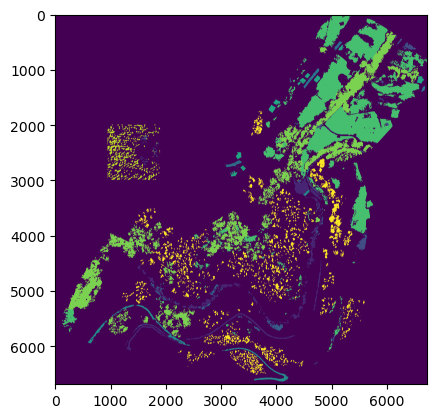

In [7]:
# Mostrar la salida

OUTPUT='../results/predictions/predictions_ResBaGAN_onnx.pgm'

(imagen_output, H, V) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V, H)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()